In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor, print_model_size

In [2]:
# Custom Depthwise Separable Convolution Block
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        # The block performs a depthwise convolution (groups=in_channels)
        # followed by a pointwise (1x1) convolution.
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, 
                      padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, 
                      padding=0, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

# MobileNet-style architecture
# This is a simplified variant adapted for CIFAR-10's 32x32 images.
class MobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            # Initial standard convolution layer
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Depthwise Separable Convolution blocks
            DepthwiseSeparableConv(32, 64, stride=1),
            DepthwiseSeparableConv(64, 128, stride=2),
            DepthwiseSeparableConv(128, 128, stride=1),
            DepthwiseSeparableConv(128, 256, stride=2),
            DepthwiseSeparableConv(256, 256, stride=1),
            DepthwiseSeparableConv(256, 512, stride=2),
            DepthwiseSeparableConv(512, 512, stride=1),
            # Global average pooling to produce a fixed 1x1 output per channel
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

In [3]:
print_model_size(MobileNet())

Total params = 5.430500e+05
Trainable params = 5.430500e+05


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

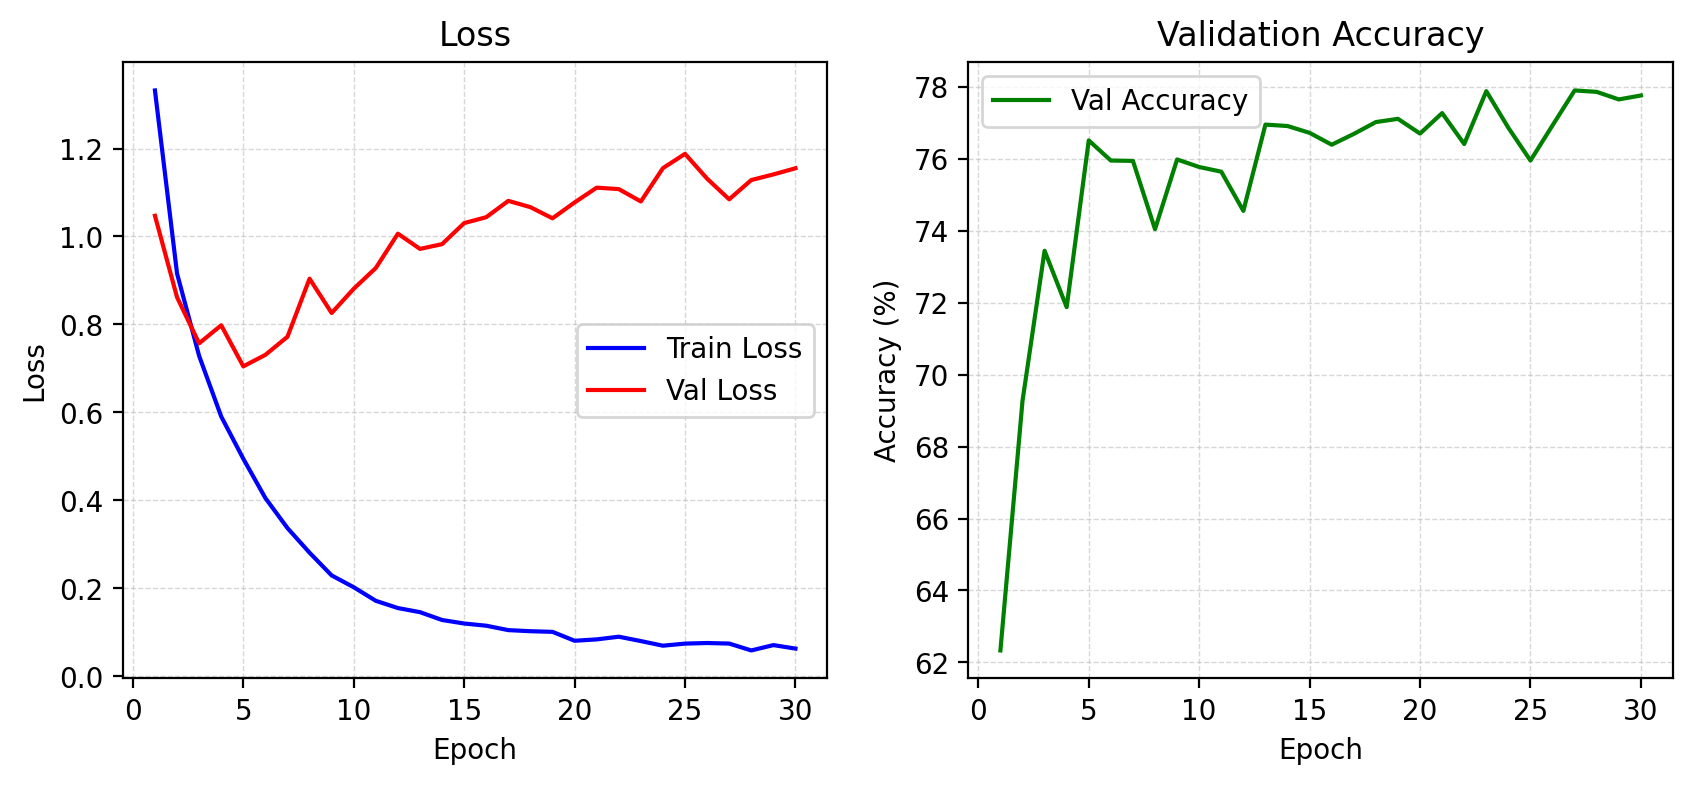

Epoch 30/30: 100%|##########| 30/30 [08:07<00:00, 18.50s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.3320       |       1.0471       |         62.3300         |
|         2          |       0.9159       |       0.8619       |         69.2700         |
|         3          |       0.7285       |       0.7572       |         73.4500         |
|         4          |       0.5908       |       0.7982       |         71.8800         |
|         5          |       0.4948       |       0.7048       |         76.5200         |
|         6          |       0.4054       |       0.7310       |         75.9600         |
|         7          |       0.3372       |       0.7721       |         75.9500         |
|         8          |       0.2812       |       0.9041       |         74.0500         |
|         9          |       0.2296       |       0.8261       |         75.9900         |

In [4]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=64)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)
